# MNLI EVAL

In [1]:
import os
from tqdm import tqdm_notebook, tqdm
import csv
import more_itertools as mit  # not built-in package
from collections import Counter
import torch
try:
    _tqdm = tqdm_notebook
except ImportError:
    _tqdm = tqdm
        

train_list = []
with open('mnli_train.tsv', 'r') as trainfile:
    train_reader = csv.reader(trainfile, delimiter='\t')
    
    for row in _tqdm(train_reader):
        train_list.append(row)
        
train_list = train_list[1:]

valid_list = []
with open('mnli_val.tsv', 'r') as valfile:
    val_reader = csv.reader(valfile, delimiter='\t')
    
    for row in _tqdm(val_reader):
        valid_list.append(row)
        
valid_list = valid_list[1:]


# making a vocabulary
all_tokens = list(mit.flatten([[ll.split() for ll in l[:2]] for l in train_list] + [[ll.split() for ll in l[:2]] for l in valid_list]))
all_tokens = list(mit.flatten(all_tokens))
all_tokens = [t.lower() for t in all_tokens]

counted_tokens = Counter(all_tokens)

In [40]:
snli_train_list = []
with open('snli_train.tsv', 'r') as trainfile:
    train_reader = csv.reader(trainfile, delimiter='\t')
    
    for row in _tqdm(train_reader):
        snli_train_list.append(row)
        
snli_train_list = snli_train_list[1:]

snli_valid_list = []
with open('snli_val.tsv', 'r') as valfile:
    val_reader = csv.reader(valfile, delimiter='\t')
    
    for row in _tqdm(val_reader):
        snli_valid_list.append(row)
        
snli_valid_list = snli_valid_list[1:]


# making a vocabulary
snli_all_tokens = list(mit.flatten([[ll.split() for ll in l[:2]] for l in snli_train_list] + [[ll.split() for ll in l[:2]] for l in snli_valid_list]))
snli_all_tokens = list(mit.flatten(snli_all_tokens))
snli_all_tokens = [t.lower() for t in snli_all_tokens]

snli_counted_tokens = Counter(snli_all_tokens)

In [7]:
train_list_per_genre = {}
for item in train_list:
    if item[-1] not in train_list_per_genre:
        train_list_per_genre[item[-1]] = [item[:-1]]
    else:
        train_list_per_genre[item[-1]].append(item[:-1])
        
valid_list_per_genre = {}
for item in valid_list:
    if item[-1] not in valid_list_per_genre:
        valid_list_per_genre[item[-1]] = [item[:-1]]
    else:
        valid_list_per_genre[item[-1]].append(item[:-1])

In [85]:
len(valid_list_per_genre['fiction'])

995

In [9]:
max_vocab_size=None
PAD_IDX=0
UNK_IDX=1

In [10]:
train_list[0]

["and now that was in fifty one that 's forty years ago that it was already a problem so it 's now uh",
 "It was already a problem forty years ago but now it 's ten times worse !",
 'neutral',
 'telephone']

In [11]:
#  init fasttext weights
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in _tqdm(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

words = load_vectors('./wiki-news-300d-1M.vec')
words_dict = {}

for w in _tqdm(words):
    words_dict[w] = torch.Tensor([c for c in words[w]])

In [41]:
import torch
from torch.utils.data import Dataset, DataLoader
from operator import itemgetter
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


vocab, count = zip(*snli_counted_tokens.most_common(max_vocab_size))
id2token = list(vocab)
token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
id2token = ['<pad>', '<unk>'] + id2token
token2id['<pad>'] = PAD_IDX 
token2id['<unk>'] = UNK_IDX

def _text2id(doc):
    return [token2id[t] if t in token2id else UNK_IDX for t in doc]

def _id2text(vec):
    return [id2token[i] for i in vec]

class MnliDataset(Dataset):
    def __init__(self, data_list, device='cpu'):
        """
        data_list is a list of tuples: (x,y) where x is a list of ids and y is a label
        """
        labels = {
            'neutral': 0,
            'entailment': 1,
            'contradiction': 2
        }
        self.data_tensors = []
        for (t1, t2, label) in _tqdm(data_list):
            _t1 = torch.LongTensor(_text2id([w.lower() for w in t1.split()])).to(device)
            _t2 = torch.LongTensor(_text2id([w.lower() for w in t2.split()])).to(device)
            _t1_length = len(t1.split())
            _t2_length = len(t2.split())
            _label = torch.LongTensor([labels[label]]).to(device)
            self.data_tensors.append([_t1, _t1_length, _t2, _t2_length, _label])
              
    def __getitem__(self, key):
        (t1, t1_len, t2, t2_len, label) = self.data_tensors[key]
        
        return t1, t1_len, t2, t2_len, label

    def __len__(self):
        return len(self.data_tensors)

def pad(tensor, length, dim=0, pad=0):
    """Pad tensor to a specific length.
    :param tensor: vector to pad
    :param length: new length
    :param dim: (default 0) dimension to pad
    :returns: padded tensor if the tensor is shorter than length
    """
    if tensor.size(dim) < length:
        return torch.cat(
            [tensor, tensor.new(*tensor.size()[:dim],
                                length - tensor.size(dim),
                                *tensor.size()[dim + 1:]).fill_(pad)],
            dim=dim)
    else:
        return tensor

In [27]:
def batchify(batch):
    maxlen_t1 = max(batch, key = itemgetter(1))[1]
    maxlen_t2 = max(batch, key = itemgetter(3))[3]
    t1_batch_list = []
    t2_batch_list = []
    target_list = []
    for b in batch:
        t1_batch_list.append(pad(b[0], maxlen_t1, dim=0, pad=PAD_IDX))
        t2_batch_list.append(pad(b[2], maxlen_t2, dim=0, pad=PAD_IDX))

        target_list.append(b[4])
    
    lengths = torch.LongTensor([(b[1],b[3]) for b in batch]).to(b[0][0].device)
    
    lens_inds = torch.sort(lengths, 0, descending=True)
    
    t1_batch_list = torch.stack(t1_batch_list, 0).index_select(0, lens_inds[1][:,0])
    t2_batch_list = torch.stack(t2_batch_list, 0).index_select(0, lens_inds[1][:,1])

    #t1_input_batch = torch.stack(t1_batch_list, 0)
    #t2_input_batch = torch.stack(t2_batch_list, 0)

    target_batch = torch.stack(target_list, 0)
    
    return t1_batch_list, t2_batch_list, target_batch, lens_inds

# for CNN
def batchify_withoutsort(batch):
    # make it for cnn
    maxlen_t1 = max(batch, key = itemgetter(1))[1]
    maxlen_t2 = max(batch, key = itemgetter(3))[3]
    t1_batch_list = []
    t2_batch_list = []
    target_list = []
    for b in batch:
        t1_batch_list.append(pad(b[0], maxlen_t1, dim=0, pad=PAD_IDX))
        t2_batch_list.append(pad(b[2], maxlen_t2, dim=0, pad=PAD_IDX))

        target_list.append(b[4])
    
#     lengths = torch.LongTensor([(b[1],b[3]) for b in batch]).to(b[0][0].device)
    
#     lens_inds = torch.sort(lengths, 0, descending=True)
    
#     t1_batch_list = torch.stack(t1_batch_list, 0).index_select(0, lens_inds[1][:,0])
#     t2_batch_list = torch.stack(t2_batch_list, 0).index_select(0, lens_inds[1][:,1])

    t1_input_batch = torch.stack(t1_batch_list, 0)
    t2_input_batch = torch.stack(t2_batch_list, 0)

    target_batch = torch.stack(target_list, 0)
    
    return t1_input_batch, t2_input_batch, target_batch

In [86]:
mnli_train = {}
mnli_valid = {}

for genre in train_list_per_genre.keys():
    mnli_train[genre] = {'dataset': MnliDataset(train_list_per_genre[genre], device='cuda')}
    mnli_train[genre]['rnn_loader'] = DataLoader(mnli_train[genre]['dataset'], batch_size=512, collate_fn=batchify, shuffle=True)
    mnli_train[genre]['cnn_loader'] = DataLoader(mnli_train[genre]['dataset'], batch_size=512, collate_fn=batchify_withoutsort, shuffle=True)
    
for genre in valid_list_per_genre.keys():
    mnli_valid[genre] = {'dataset': MnliDataset(valid_list_per_genre[genre], device='cuda')}
    mnli_valid[genre]['rnn_loader'] = DataLoader(mnli_valid[genre]['dataset'], batch_size=512, collate_fn=batchify, shuffle=False)
    mnli_valid[genre]['cnn_loader'] = DataLoader(mnli_valid[genre]['dataset'], batch_size=512, collate_fn=batchify_withoutsort, shuffle=False)


# snli_train_dataset = SnliDataset(train_list, device='cuda')
# train_loader = DataLoader(snli_train_dataset, batch_size=512, collate_fn=batchify, shuffle=True)

# snli_valid_dataset = SnliDataset(valid_list, device='cuda')
# valid_loader = DataLoader(snli_valid_dataset, batch_size=512, collate_fn=batchify, shuffle=False)

In [90]:
mnli_valid['telephone']['dataset'][1]

(tensor([19784, 20900,   220,  6135,   579,     1], device='cuda:0'),
 6,
 tensor([    4, 11610,    11, 20900,     6,   165,   579,     1], device='cuda:0'),
 8,
 tensor([1], device='cuda:0'))

In [91]:
mnli_valid['fiction']['dataset'][1]

(tensor([  142,  4529,  1280,    16,   744,   142,  1023,  1280,     3,   296,
             1, 18806,    92,     3], device='cuda:0'),
 14,
 tensor([ 142, 2182, 4529, 1280,   16,  853,  142, 3768,   54,  186, 1280,    1,
            3], device='cuda:0'),
 13,
 tensor([2], device='cuda:0'))

In [68]:
import torch.nn as nn
#  copy fasttext vectors into embeddings weights given the vocabulary

class RNNEncoder(nn.Module):
    def __init__(self, hidden_size, id2token, embedding_size=300, num_layers=1, classifier_hidden=512, dropout=0.0):
        super().__init__()
        self.embedding = self._copy_embedding_weights(words, id2token, embedding_size)
        self.encoder = nn.GRU(num_layers=num_layers, hidden_size=hidden_size, bias=True, input_size=embedding_size, batch_first=True,
                             bidirectional=True)
        
        self.classifier = nn.ModuleList([nn.Linear(4*hidden_size, classifier_hidden), nn.Tanh(), nn.Dropout(p=dropout), nn.Linear(classifier_hidden, 3)])
        

    def _copy_embedding_weights(self, words, id2token, embedding_size=300):
        embedding = nn.Embedding(embedding_dim=embedding_size, num_embeddings=len(id2token), padding_idx=0)
        cnt = 0
        for i,w in enumerate(id2token):
            if w in words:
                embedding.weight.data[i] = words_dict[w]
                cnt +=1 
        print('{} words copied into nn.Embedding'.format(cnt))
        return embedding
        
    def forward(self, t1, t2, lens_inds):
        t1_embedded = self.embedding(t1)
        t2_embedded = self.embedding(t2)
        t1_packed = pack_padded_sequence(t1_embedded, lens_inds[0][:,0], batch_first=True)
        t2_packed = pack_padded_sequence(t2_embedded, lens_inds[0][:,1], batch_first=True)
        
        t1_grued = self.encoder(t1_packed)
        t2_grued = self.encoder(t2_packed)
        t1_out = torch.cat(torch.unbind(t1_grued[1], 0), dim=-1)
        t2_out = torch.cat(torch.unbind(t2_grued[1], 0), dim=-1)
        #import ipdb; ipdb.set_trace()
        # need to reorder back firstly
        #assert len(sorted_indices[0]) == len(sorted_indices[1])
        t1_out = t1_out.index_select(dim=0, index=torch.sort(lens_inds[1][:,0])[1])
        t2_out = t2_out.index_select(dim=0, index=torch.sort(lens_inds[1][:,1])[1])
        
        classifier_input = torch.cat([t1_out, t2_out], dim=-1)

        x = classifier_input
        for l in self.classifier:
            x = l(x)
        
        class_out = x
        
        return class_out

In [30]:
import torch.nn.functional as F

class CNNEncoder(nn.Module):
    def __init__(self, hidden_size, id2token, embedding_size=300, num_layers=1, classifier_hidden=512, kernel_size=3, pool_kernel_size=2, dropout=0.5):
        super().__init__()
        self.embedding = self._copy_embedding_weights(words, id2token, embedding_size)
        self.embedding.weight.requires_grad=False
        self.encoder = nn.ModuleList([nn.Conv1d(in_channels=embedding_size, out_channels=hidden_size, kernel_size=kernel_size, stride=1), nn.MaxPool1d(stride=1, kernel_size=pool_kernel_size) , nn.ReLU(), nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, stride=1), nn.Dropout(p=dropout)])
        
        self.classifier = nn.ModuleList([nn.Linear(2*hidden_size, classifier_hidden), nn.Tanh(), nn.Dropout(p=dropout), nn.Linear(classifier_hidden, 3)])
        

    def _copy_embedding_weights(self, words, id2token, embedding_size=300):
        embedding = nn.Embedding(embedding_dim=embedding_size, num_embeddings=len(id2token), padding_idx=0)
        cnt = 0
        for i,w in enumerate(id2token):
            if w in words:
                embedding.weight.data[i] = words_dict[w]
                cnt +=1 
        print('{} words copied into nn.Embedding'.format(cnt))
        return embedding
    
    def _encode(self, x):
        for l in self.encoder:
            x = l(x)
            
        return x
    
    def _classify(self, x):
        for l in self.classifier:
            x = l(x)
            
        return x
        
    def forward(self, t1, t2):
        embedded = []
        embedded.append(self.embedding(t1))
        embedded.append(self.embedding(t2))
           
        cnn_out = []
        
        for i in range(2):
            _out = self._encode(embedded[i].permute(0,2,1))
            cnn_out.append(F.max_pool1d(_out , kernel_size=_out.size(-1)).squeeze(-1))
            #import ipdb; ipdb.set_trace()
            
        #import ipdb; ipdb.set_trace()

        classifier_input = torch.cat(cnn_out, dim=1)
        classifier_out = self._classify(classifier_input)
        
        
        return classifier_out

# loading CNN grids pkl

In [77]:
import pickle
with open('cnn_grid.pkl', 'rb') as f:
    grids = pickle.load(f)

In [103]:
best_val_model = 0
best_grid = None
for model in grids:
    if model[-1]['valid_acc'] > best_val_model:
        best_grid = model
        best_val_model = model[-1]['valid_acc']

In [104]:
best_val_model

0.669

In [105]:
cnnmodel

CNNEncoder(
  (embedding): Embedding(21115, 300, padding_idx=0)
  (encoder): ModuleList(
    (0): Conv1d(300, 256, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (4): Dropout(p=0.0)
  )
  (classifier): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0)
    (3): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [80]:
best_conf = best_grid[-1]['configuration']
cnnmodel = CNNEncoder(best_conf['cnn_hidden'], id2token, classifier_hidden=512, dropout=best_conf['dropout'], embedding_size=300)

19027 words copied into nn.Embedding


In [81]:
cnnmodel.load_state_dict(best_grid[-1]['model_dict'])
cnnmodel = cnnmodel.cuda()

In [101]:
def _do_valid_rnn(rnnencoder, valid_loader, metrics, mode='valid'):
    rnnencoder.eval()
    correct = 0
    processed = 0
    for i,(t1,t2,target, lens) in enumerate(valid_loader):
        output = rnnencoder(t1,t2, lens)
        predicted = torch.argmax(output, 1)
        correct += (target.view(-1) == predicted.view(-1)).sum().item()
        processed += predicted.size(0)
        if i == 25 and mode == 'train':
            break
    print('Acc {}: {}'.format(mode, correct/processed))
    
def _do_valid_cnn(cnnencoder, valid_loader, metrics, mode='valid'):
    cnnencoder.eval()
    correct = 0
    processed = 0
    for i,(t1,t2,target) in enumerate(valid_loader):
        output = cnnencoder(t1,t2)
        predicted = torch.argmax(output, 1)
        correct += (target.view(-1) == predicted.view(-1)).sum().item()
        processed += predicted.size(0)
        if i == 25 and mode == 'train':
            break
    print('Acc {}: {}'.format(mode, correct/processed))

In [94]:
for gengre in valid_list_per_genre.keys():
    _do_valid_cnn(cnnmodel, mnli_valid[genre]['cnn_loader'], metrics)

Acc valid: 0.3574338085539715
Acc valid: 0.3574338085539715
Acc valid: 0.3574338085539715
Acc valid: 0.3574338085539715
Acc valid: 0.3574338085539715


In [57]:
ipdb.pm()

> <ipython-input-48-f92caf61d699>(19)_do_valid_cnn()
     18     processed = 0
---> 19     for i,(t1,t2,target) in enumerate(valid_loader):
     20         output = cnnencoder(t1,t2)



ipdb>  valid_loader


ipdb>  for t in valid_loader: print(t)


(tensor([[    9,  1428,   205,  ...,  4816,   142,  1089],
        [13373,   142,  2471,  ...,     0,     0,     0],
        [    1,     4,     4,  ...,     0,     0,     0],
        ...,
        [18872,  3499,     0,  ...,     0,     0,     0],
        [11664,     1,     0,  ...,     0,     0,     0],
        [  626,   317,     0,  ...,     0,     0,     0]], device='cuda:0'), tensor([[  193,    35,  1474,  ..., 10620,   862,     3],
        [   92,  1738,   469,  ...,     0,     0,     0],
        [ 1428,  2471,  1082,  ...,     0,     0,     0],
        ...,
        [ 7905,  1280,  2493,  ...,     0,     0,     0],
        [10008,  2605,     0,  ...,     0,     0,     0],
        [    1,     0,     0,  ...,     0,     0,     0]], device='cuda:0'), tensor([[2],
        [2],
        [2],
        [0],
        [2],
        [0],
        [2],
        [0],
        [2],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [2],
        [2],
        [0],
     

ipdb>  exit


## loading RNN grids pkl

In [96]:
with open('rnn_grid.pkl', 'rb') as f:
    rnn_grids = pickle.load(f)

In [97]:
best_val_model = 0
best_grid = None
for model in rnn_grids:
    if model[-1]['valid_acc'] > best_val_model:
        best_grid = model
        best_val_model = model[-1]['valid_acc']

In [98]:
best_val_model

0.646

In [106]:
rnnmodel

RNNEncoder(
  (embedding): Embedding(21115, 300, padding_idx=0)
  (encoder): GRU(300, 512, batch_first=True, bidirectional=True)
  (classifier): ModuleList(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0)
    (3): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [99]:
best_conf = best_grid[-1]['configuration']
rnnmodel = RNNEncoder(best_conf['rnn_hidden'], id2token, classifier_hidden=512, embedding_size=300, dropout=best_conf['dropout'])
rnnmodel.load_state_dict(best_grid[-1]['model_dict'])
rnnmodel = rnnmodel.cuda()

19027 words copied into nn.Embedding


In [102]:
for gengre in train_list_per_genre.keys():
    _do_valid_rnn(rnnmodel, mnli_valid[genre]['rnn_loader'], metrics)

Acc valid: 0.40224032586558045
Acc valid: 0.40224032586558045
Acc valid: 0.40224032586558045
Acc valid: 0.40224032586558045
Acc valid: 0.40224032586558045


In [116]:
import altair as alt
metrics = [[ii,i,j,k] for ii,(i,j,k) in enumerate(zip(best_grid[0]['train_loss'], best_grid[0]['train_acc'], best_grid[0]['valid_acc']))]

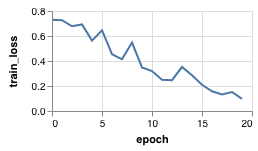

In [125]:
import pandas
df = pandas.DataFrame(metrics, columns=['epoch', 'train_loss', 'train_acc', 'valid_acc'])

alt.Chart(df).mark_line().encode(
    alt.X('epoch', scale=alt.Scale()),
    alt.Y('train_loss')).properties(
        width=200,
        height=100
    )

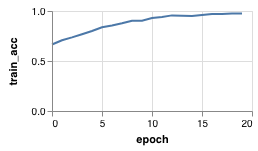

In [126]:
alt.Chart(df).mark_line().encode(
    alt.X('epoch', scale=alt.Scale()),
    alt.Y('train_acc')).properties(
        width=200,
        height=100
    )

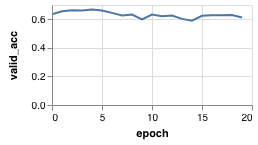

In [127]:
alt.Chart(df).mark_line().encode(
    alt.X('epoch', scale=alt.Scale()),
    alt.Y('valid_acc')).properties(
        width=200,
        height=100
    )